In [1]:
import os 
import sys
import random
import math
import numpy as np
import pandas as pd 
import glob 
import json
from matplotlib import pyplot as plt

import cv2
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm

In [2]:
DATA_DIR = '../data'
TRAIN_DIR = os.path.join(DATA_DIR, 'stage_1_train_images')
TEST_DIR = os.path.join(DATA_DIR, 'stage_1_test_images')

MODEL_DIR = '../model/Mask_RCNN'
COCO_WEIGHTS_PATH = os.path.join(MODEL_DIR, 'mask_rcnn_coco.h5')
ORIG_SIZE = 1024

In [3]:
# Import Mask RCNN
sys.path.append(os.path.join(MODEL_DIR))  # To find local version of the library
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [4]:
from pneumonia import PneumoniaDataset2, PneumoniaConfig2
from functions import parse_dataset

In [5]:
# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal 

config = PneumoniaConfig2()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_mask_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'rpn_class_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

In [6]:
# Parse dataset
annotations = pd.read_csv(os.path.join(DATA_DIR, 'stage_1_train_labels_2.csv'))
image_fps, image_annotations = parse_dataset(TRAIN_DIR, annotations)

In [7]:
# Split dataset into training vs. validation dataset
image_fps_train = pd.read_csv('image_fps_train.csv').image_fps_train.tolist()
image_fps_val = pd.read_csv('image_fps_val.csv').image_fps_val.tolist()
print('train_size=', len(image_fps_train))
print('validation_size=', len(image_fps_val))

train_size= 24184
validation_size= 1500


In [8]:
# Prepare the training dataset
dataset_train = PneumoniaDataset2(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

# Prepare the validation dataset
dataset_val = PneumoniaDataset2(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

In [9]:
# Image augmentation (light but constant)
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5),
    
    iaa.OneOf([ ## geometric transform
        iaa.Affine(
            scale={"x": (0.98, 1.02), "y": (0.98, 1.02)},
            translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
            rotate=(-2, 2),
            shear=(-1, 1),
        ),
        iaa.PiecewiseAffine(scale=(0.001, 0.025)),
    ]),
    
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ])
])

In [10]:
# Build model
model = modellib.MaskRCNN(mode='training', config=config, model_dir=MODEL_DIR)

# Exclude the last layers because they require a matching
# number of classes
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])

In [11]:
%%time
# Train model
LEARNING_RATE = 0.001

## train heads with higher lr to speedup the learning
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE*2,
            epochs=2,
            layers='heads',
            augmentation=None)  ## no need to augment yet

history = model.keras_model.history.history


Starting at epoch 0. LR=0.002

Checkpoint Path: ../model/Mask_RCNN/pneumonia20181021T0214/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_b

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/2
500/500 [==============================] - 668s 1s/step - loss: 1.7834 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.4059 - mrcnn_class_loss: 0.4714 - mrcnn_bbox_loss: 0.4922 - mrcnn_mask_loss: 0.3937 - val_loss: 1.4994 - val_rpn_class_loss: 0.0143 - val_rpn_bbox_loss: 0.2679 - val_mrcnn_class_loss: 0.4655 - val_mrcnn_bbox_loss: 0.4084 - val_mrcnn_mask_loss: 0.3432
Epoch 2/2
500/500 [==============================] - 546s 1s/step - loss: 1.4610 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.2916 - mrcnn_class_loss: 0.4323 - mrcnn_bbox_loss: 0.3773 - mrcnn_mask_loss: 0.3468 - val_loss: 1.4615 - val_rpn_class_loss: 0.0129 - val_rpn_bbox_loss: 0.3245 - val_mrcnn_class_loss: 0.4233 - val_mrcnn_bbox_loss: 0.3507 - val_mrcnn_mask_loss: 0.3501
CPU times: user 53min 19s, sys: 34min 16s, total: 1h 27min 36s
Wall time: 20min 58s


In [12]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=6,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 2. LR=0.001

Checkpoint Path: ../model/Mask_RCNN/pneumonia20181021T0214/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2

Epoch 3/6
500/500 [==============================] - 1673s 3s/step - loss: 1.2223 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2370 - mrcnn_class_loss: 0.3677 - mrcnn_bbox_loss: 0.2837 - mrcnn_mask_loss: 0.3251 - val_loss: 1.0769 - val_rpn_class_loss: 0.0082 - val_rpn_bbox_loss: 0.2421 - val_mrcnn_class_loss: 0.3011 - val_mrcnn_bbox_loss: 0.2361 - val_mrcnn_mask_loss: 0.2893
Epoch 4/6
500/500 [==============================] - 1537s 3s/step - loss: 1.0930 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.2232 - mrcnn_class_loss: 0.3209 - mrcnn_bbox_loss: 0.2388 - mrcnn_mask_loss: 0.3029 - val_loss: 1.0468 - val_rpn_class_loss: 0.0066 - val_rpn_bbox_loss: 0.2167 - val_mrcnn_class_loss: 0.3012 - val_mrcnn_bbox_loss: 0.2390 - val_mrcnn_mask_loss: 0.2832
Epoch 5/6
500/500 [==============================] - 1550s 3s/step - loss: 1.0012 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1948 - mrcnn_class_loss: 0.2974 - mrcnn_bbox_loss: 0.2179 - mrcnn_mask_loss: 0.2851 - val_loss: 0.9821 - val_rpn_class_l

In [13]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/5,
            epochs=14,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 6. LR=0.0002

Checkpoint Path: ../model/Mask_RCNN/pneumonia20181021T0214/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch

Epoch 7/14
500/500 [==============================] - 1644s 3s/step - loss: 0.8942 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.1777 - mrcnn_class_loss: 0.2571 - mrcnn_bbox_loss: 0.1883 - mrcnn_mask_loss: 0.2659 - val_loss: 0.8892 - val_rpn_class_loss: 0.0056 - val_rpn_bbox_loss: 0.1965 - val_mrcnn_class_loss: 0.2449 - val_mrcnn_bbox_loss: 0.1896 - val_mrcnn_mask_loss: 0.2526
Epoch 8/14
500/500 [==============================] - 1543s 3s/step - loss: 0.8550 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.1653 - mrcnn_class_loss: 0.2444 - mrcnn_bbox_loss: 0.1811 - mrcnn_mask_loss: 0.2594 - val_loss: 0.8745 - val_rpn_class_loss: 0.0056 - val_rpn_bbox_loss: 0.1983 - val_mrcnn_class_loss: 0.2338 - val_mrcnn_bbox_loss: 0.1909 - val_mrcnn_mask_loss: 0.2460
Epoch 9/14
500/500 [==============================] - 1583s 3s/step - loss: 0.8588 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.1662 - mrcnn_class_loss: 0.2452 - mrcnn_bbox_loss: 0.1820 - mrcnn_mask_loss: 0.2607 - val_loss: 0.8680 - val_rpn_clas

In [14]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/50,
            epochs=20,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 14. LR=2e-05

Checkpoint Path: ../model/Mask_RCNN/pneumonia20181021T0214/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch

Epoch 15/20
500/500 [==============================] - 1655s 3s/step - loss: 0.8000 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.1520 - mrcnn_class_loss: 0.2208 - mrcnn_bbox_loss: 0.1717 - mrcnn_mask_loss: 0.2511 - val_loss: 0.8339 - val_rpn_class_loss: 0.0050 - val_rpn_bbox_loss: 0.1869 - val_mrcnn_class_loss: 0.2186 - val_mrcnn_bbox_loss: 0.1831 - val_mrcnn_mask_loss: 0.2403
Epoch 16/20
500/500 [==============================] - 1520s 3s/step - loss: 0.8158 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.1606 - mrcnn_class_loss: 0.2268 - mrcnn_bbox_loss: 0.1721 - mrcnn_mask_loss: 0.2518 - val_loss: 0.8407 - val_rpn_class_loss: 0.0054 - val_rpn_bbox_loss: 0.1875 - val_mrcnn_class_loss: 0.2239 - val_mrcnn_bbox_loss: 0.1849 - val_mrcnn_mask_loss: 0.2390
Epoch 17/20
500/500 [==============================] - 1574s 3s/step - loss: 0.7983 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.1514 - mrcnn_class_loss: 0.2221 - mrcnn_bbox_loss: 0.1706 - mrcnn_mask_loss: 0.2499 - val_loss: 0.8301 - val_rpn_c

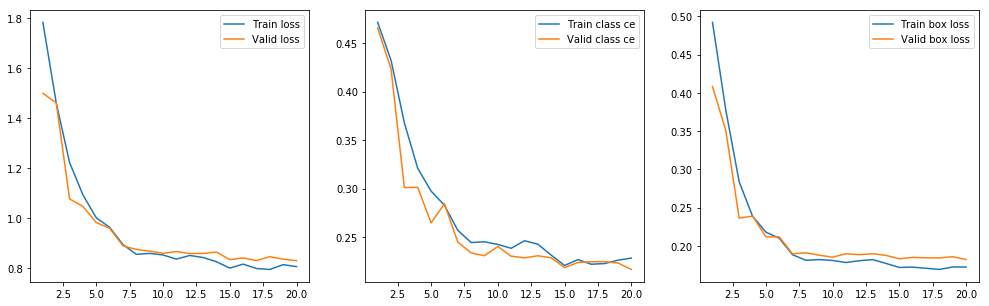

In [15]:
# Plot loss
epochs = range(1,len(next(iter(history.values())))+1)
df_history = pd.DataFrame(history, index=epochs)

plt.figure(figsize=(17,5))

plt.subplot(131)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid class ce")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid box loss")
plt.legend()

plt.show()

In [16]:
best_epoch = np.argmin(history["val_loss"])
print("Best Epoch:", best_epoch + 1)

Best Epoch: 20


In [17]:
df_history

,loss,mrcnn_bbox_loss,mrcnn_class_loss,mrcnn_mask_loss,rpn_bbox_loss,rpn_class_loss,val_loss,val_mrcnn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_mask_loss,val_rpn_bbox_loss,val_rpn_class_loss
1,1.783435,0.492238,0.471380,0.393739,0.405950,0.020127,1.499441,0.408409,0.465534,0.343215,0.267936,0.014345
2,1.461033,0.377315,0.432321,0.346816,0.291596,0.012983,1.461500,0.350707,0.423338,0.350100,0.324485,0.012867
3,1.222336,0.283695,0.367748,0.325109,0.237042,0.008736,1.076870,0.236131,0.301059,0.289343,0.242127,0.008202
4,1.092995,0.238759,0.320888,0.302890,0.223158,0.007292,1.046781,0.238991,0.301248,0.283220,0.216701,0.006614
5,1.001233,0.217938,0.297445,0.285090,0.194769,0.005984,0.982135,0.211784,0.264693,0.264879,0.233866,0.006906
6,0.963161,0.209953,0.282877,0.278296,0.186716,0.005312,0.959255,0.211692,0.284296,0.261474,0.196218,0.005568
7,0.894157,0.188276,0.257061,0.265856,0.177716,0.005241,0.889200,0.189555,0.244918,0.252627,0.196451,0.005642
8,0.855014,0.181101,0.244417,0.259359,0.165296,0.004834,0.874511,0.190905,0.233760,0.245992,0.198294,0.005552
9,0.858816,0.181968,0.245189,0.260689,0.166170,0.004793,0.868034,0.187727,0.230852,0.245408,0.198553,0.005486
10,0.852636,0.180860,0.242477,0.258408,0.166388,0.004495,0.859158,0.185136,0.240380,0.242079,0.186343,0.005212


In [18]:
df_history.to_csv('df_history.csv', index=False)